# Audio Data Processing

In this notebook, we will undergo a few data processing steps targeted to audio signals.

In this sample we will learn how to load, listen, resample, visualize, and extract a few relevant features from audio.

In [81]:
import numpy as np
import scipy.signal as sig
import os
from tqdm import tqdm
from scipy.io import wavfile
import sounddevice as sd  # Play audios
#import python_speech_features as spf  # Feature Extraction on speech data
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale, scale, robust_scale
from pydub import AudioSegment  # Extract audio from .webm files
import librosa

In [405]:
def plot_audio(signal, fs):
    fig = plt.figure(figsize=(12, 8))
    tt = np.linspace(0, len(signal)/fs, len(signal))
    plt.plot(tt, signal)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitdude")
    
    
def crop_silence(signals, lim_db=30, max_dur=None, frame_l=0.040, frame_h=0.030, fs=10000, merge=True, ref=np.max):
    """Librosa's silence cropping method"""
    sig_crop, n_crop, indexes = [], [], []
    for idx, i in enumerate(tqdm(signals, desc='Crop Silence')):

        lim_max = max_dur if max_dur is not None else len(i)
        print(lim_max)

        crop_idx = lb.effects.split(y=i, top_db=lim_db,
                                    frame_length=int(frame_l * fs),
                                    hop_length=int(frame_h * fs), ref=ref)
        new_seq = np.array([i[j[0]:j[1]] for j in crop_idx if (j[1] - j[0] < lim_max)])

        # Merging (or not) the extracted non-silent chunks
        if merge:
            sig_crop.append(np.concatenate(new_seq)) if len(new_seq) != 0 else None
        else:
            sig_crop.append(new_seq) if len(new_seq) != 0 else None

        # Store non-cropped signal indexes
        indexes.append(idx) if len(new_seq) == 0 else None
        n_crop.append(len(new_seq))
    print(n_crop)
    return np.array(sig_crop), indexes


def spectrogram(signals, window, overlap, fs, log=True, mel_spec=False):
    freq, time, power = [], [], []
    if mel_spec:
        for i in tqdm(signals, desc='Spectograms'):
            power.append(lb.power_to_db(lb.feature.melspectrogram(y=i, sr=fs, n_fft=window,
                                                                  hop_length=int((1 - overlap) * window),
                                                                  window='hann', power=2.0)))
            freq.append(2595 * np.log10(1 + np.linspace(0, fs / 2, power[-1].shape[-2]) / 700))
    else:
        for i in tqdm(signals, desc='Spectograms'):
            ff, tt, pxx = sig.spectrogram(x=i, fs=fs, nperseg=window,
                                          noverlap=int(overlap * window))
            freq.append(ff)
            time.append(tt)
            power.append(np.log(pxx + 1e-12) if log else pxx)
    return freq, time, power


def spec_plot(power, freq, time, log_magnitude=False, figure=None):
    plt.figure(figsize=(10, 8)) if figure is None else plt.figure(figure)
    Sxx = np.log(power) if log_magnitude else power
    plt.pcolormesh(time, freq, Sxx, shading='gouraud')
    plt.colorbar()
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
def corrupted_signal():
    s, sr = librosa.load('Data/voice6.wav')
    tt_noise = np.linspace(0, len(s)/sr, len(s))
    s_noise = np.sin(2*np.pi*1800*tt_noise)
    s_noise2 = np.sin(2*np.pi*1700*tt_noise)
    s_noise3 = np.sin(2*np.pi*2200*tt_noise)
    s = s/5
    s3 = s_noise + s_noise2 + s_noise3 + s
    return s3, sr

## Load an audio file

In [101]:
s1, sr1 = librosa.load('Data/violin.wav') # Signal + Sample rate

In [76]:
# Listen to it
sd.play(s1, samplerate=sr1)

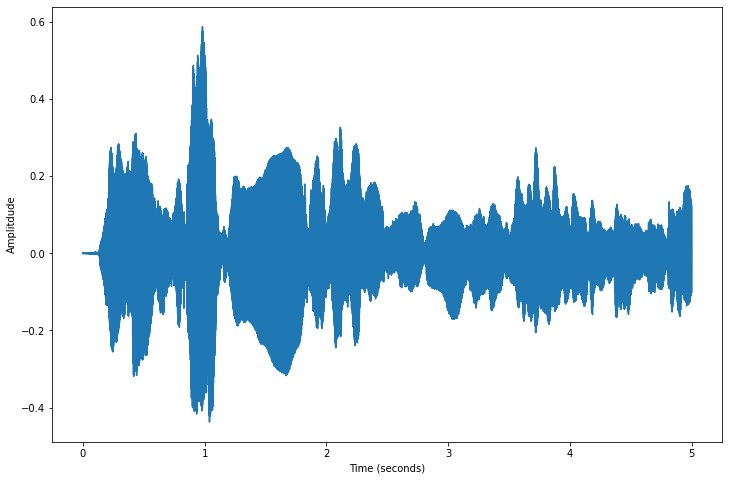

In [77]:
# Plot the audio signal
plot_audio(s1, sr1)

In [78]:
# Let's try another audio
s2, sr2 = librosa.load('Data/applause.wav')
print(sr2)

22050


In [61]:
# Listen to it again
sd.play(s2, samplerate=sr2)

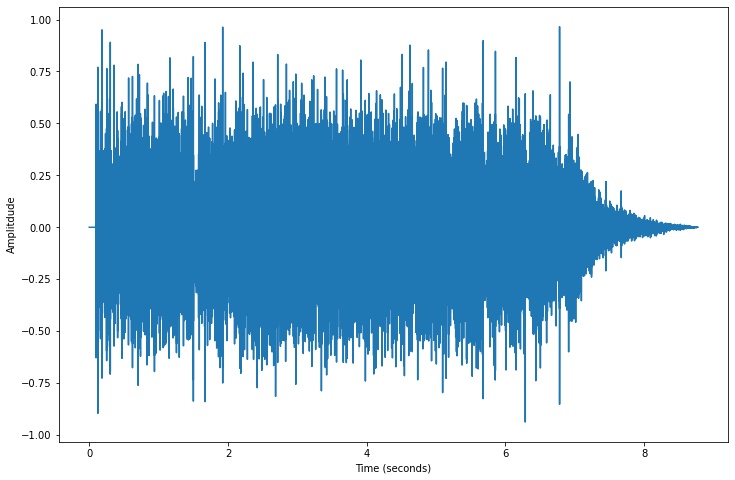

In [79]:
# Plot the audio signal
plot_audio(s2, sr2)

Seems a little different right? Nonetheless, you can't still say exatly what's different, but only that it seems different

Let's map the signal from the time to the spectral (frequency) domain (see figure below)

![title](img/freq_domain.jpeg)

## Audio Spectrogram

In [99]:
# Let's turn back to the previous examples
win_size = 0.060
overlap=0.50

window = lambda x: int(win_size * x)

### Violin

In [103]:
# Violin first
ff1, tt1, power1 = spectrogram(signals=[s1], window=window(sr1), overlap=overlap, fs=sr, log=True)

Spectograms: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.28it/s]


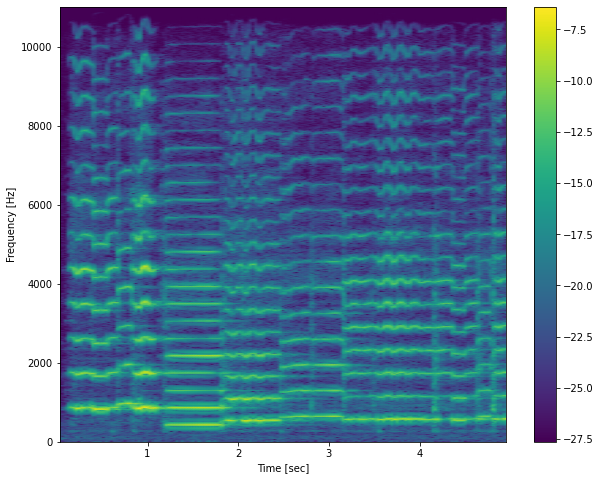

In [104]:
# Spectrogram
spec_plot(power=power1[0], freq=ff1[0], time=tt1[0], log_magnitude=False)

### Applause

In [106]:
# The applause now
ff2, tt2, power2 = spectrogram(signals=[s2], window=window(sr2), overlap=overlap, fs=sr, log=True)

Spectograms: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.27it/s]


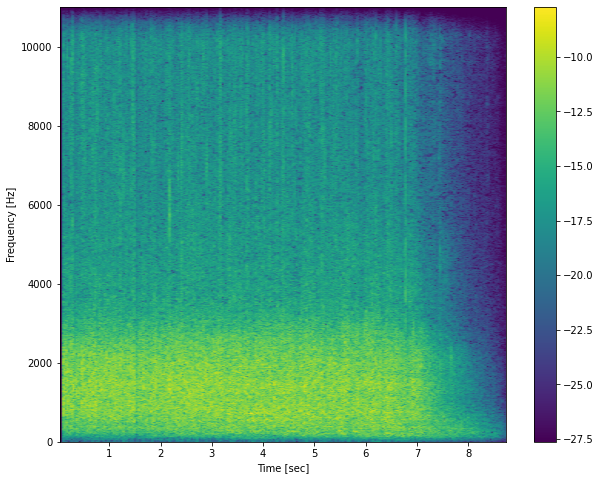

In [107]:
# Spectrogram
spec_plot(power=power2[0], freq=ff2[0], time=tt2[0], log_magnitude=False)

The spectral pattern each sound shows is totally different, right?
Now let's try to see the pattern of a person talking...

In [108]:
# Voice loading
s3, sr3 = librosa.load('Data/voice2.wav') # Signal + Sample rate

In [115]:
sd.play(s3, samplerate=sr3)

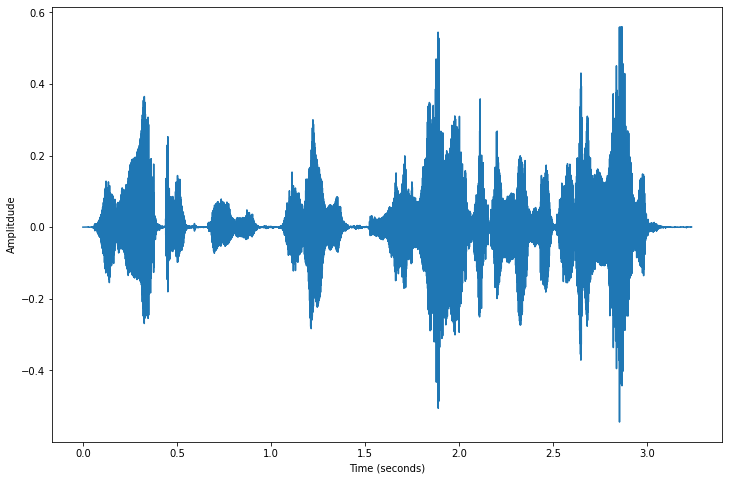

In [110]:
plot_audio(signal=s3, fs=sr3)

In [113]:
# Spectrogram
ff3, tt3, power3 = spectrogram(signals=[s3], window=window(sr3), overlap=overlap, fs=sr, log=True)

Spectograms: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


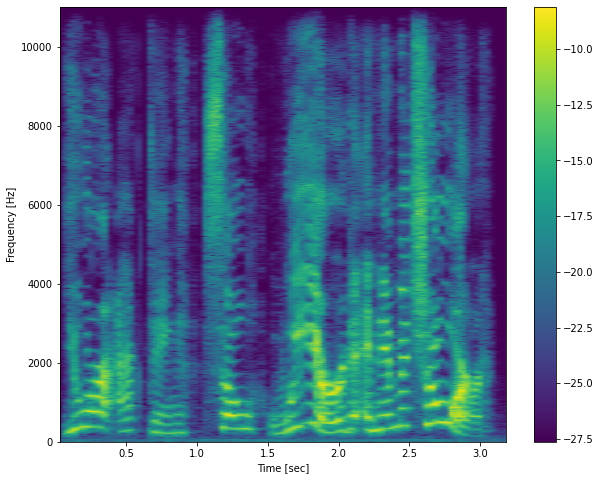

In [114]:
# Spectrogram plot
spec_plot(power=power3[0], freq=ff3[0], time=tt3[0], log_magnitude=False)

That's how a speech audio chunk looks like in the spectral domain. The vowels, the different types of sounds produced to pronounce words... It's all here, stored in a spectral pattern.

One question: can you identify where the silences between words are through this spectrogram?

## Exercise 1 - Filtering

The first challenge is the following: go back to work with the violin audio signal and try to remove the instrument's sound from the audio, as much as you can. Try to figure out the fundamental frequency and remove it.
Then, make a graphical plot of both signals before/after filtering. 

Listen to the new filtered signal. Do you still hear the sound you wanted to remove?

After you've done that, please load 'Data/trumpet.wav', 'Data/saxophone.wav', and 'Data/gunshot.wav' and try to do the same thing --> supress these sounds as much as possible.

For filtering the signal, please use 'novainstrumentation' library (tip: lowpass() function).

In [116]:
import novainstrumentation as ni

## Exercise 2 - Isolating voice

Whether you believe it or not, the following audio file contains a speech sentence pronounced by a person. But it seems corrupted with some overlaped noise.

Using some audio filtering tools you have applied in the previous exercise, would you be able to discover what the person is saying?

Make use of visualization tools such as the spectrogram you have seen before, as well as listening ones ('sd.play()').

Once you discover what the person saying, plot the signal spectrograms both before and after processing and see the differences.

In [406]:
# The audio signal and its sampling rate
s, sr = corrupted_signal()

In [407]:
# Listening to the audio
sd.play(s, samplerate=sr)

## Exercise 3 - Crop silences

In this exercise, you'll be asked to crop the silences in the audio below.
Use the "crop_silences()" function provided at the top of this notebook.

Play with the function's parameters and see how that does affect the cropping of such audio. 

The audio refers to the pronouciation of the 5 vowels ('a', 'e', 'i', 'o', and 'u') with a pause between each one. 

Can you isolate these 5 vowels in different audio chunks? 
If so, compute the spectrogram visualization of each one, and set up the differences on the patterns shown. 

In [413]:
# Load speech audio file
s, sr = librosa.load('Data/vocals1.wav')

In [424]:
# Listen to it
sd.play(s, samplerate=sr)

In [ ]:
# Use the crop_silences() function provided
chunks, _ = crop_silence(signals=[s], lim_db=, max_dur=None, frame_l=, frame_h=, fs=sr, merge=False)